Code to build and save various hidden weight initializations.

In [4]:
import sys

sys.path.append("..")
import BuildHiddenWeights as bhw  # builders
import HiddenWeightHelpers as hw  # plots, stats, norms, saving, open-loop
from RNN_Class import *
import math, torch, torch.nn as nn

In [6]:
SAVE_DIR = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN"
N = 100
NOISE_STD = 1e-2  # try 5e-3 to 1e-2
SEED = 42
HIDDEN_N = 100
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)

# Baseline

In [7]:
# prepare input -- asymmetric Gaussian
loaded = torch.load("../data/Ns100_SeqN100/encodings/Ns100_SeqN100_asym1.pth.tar")
pred = 1
X = loaded["X_mini"]
Y = loaded["Target_mini"]
X = X[:, :-pred]
Y = Y[:, pred:]

# build model (sigmoid head, W_xh identity) -- used for baseline
model = ElmanRNN_pytorch_module_v2(HIDDEN_N, HIDDEN_N, HIDDEN_N)
model.act = nn.Sigmoid()

empirical var ≈ 0.003338, theoretical var ≈ 0.003333
INITIAL MATRICES


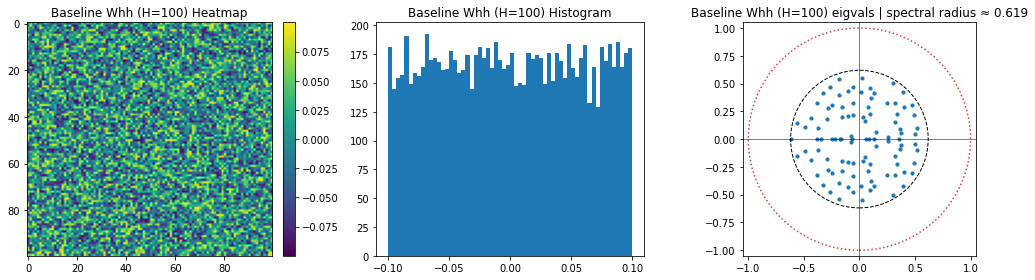

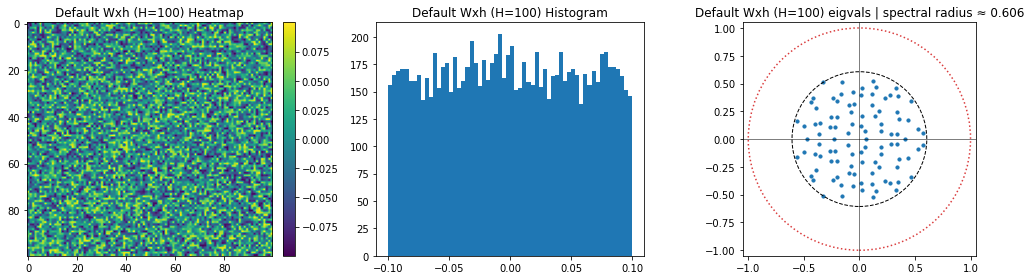

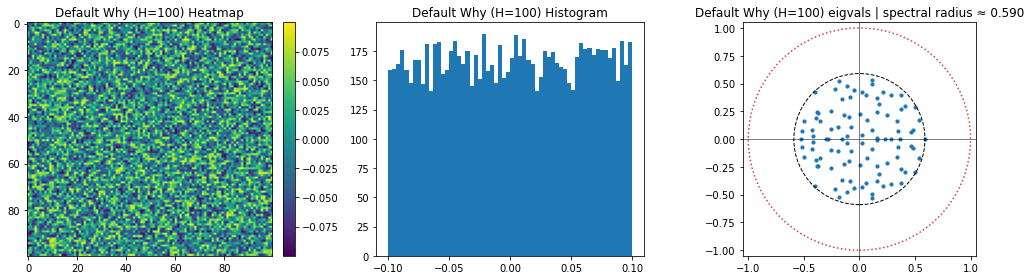

INITIAL SYMMETRY
[Random (raw) — symmetric] var=0.00168149  σ_max=0.7939  ρ=0.7939  asym=0.0000  mean=2.575e-04
[ Random (raw) — skew] var=0.00165674  σ_max=0.8127  ρ=0.8127  asym=2.0000  mean=-1.192e-11


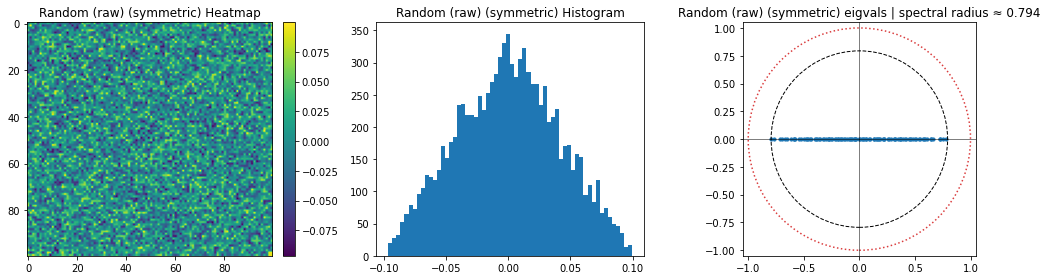

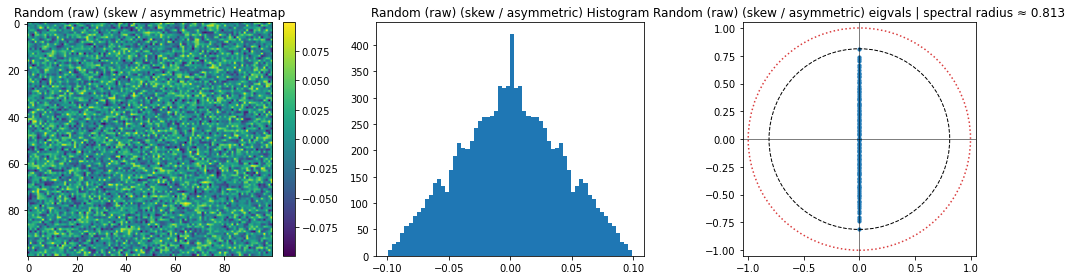

'\nhw.save_matrix(\n    W,\n    save_dir,\n    f"random_baseline",\n    meta={\n        "n": hidden_n,\n    },\n)\n'

In [8]:
# --- Baseline (random) ---
# Baseline random initialization
W, W_xh, W_hy = hw.get_numpy_weights(model)
emp_var = float(W.var())
print(f"empirical var ≈ {emp_var:.6f}, theoretical var ≈ {THEO_VAR:.6f}")
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Baseline Whh (H={HIDDEN_N})")
hw.plot_weight_all(W_xh, title=f"Default Wxh (H={HIDDEN_N})")
hw.plot_weight_all(W_hy, title=f"Default Why (H={HIDDEN_N})")

# 1) Symmetric / skew plots
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Random (raw)")

# 3) Save the baseline matrix
save_dir = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN"
"""
hw.save_matrix(
    W,
    save_dir,
    f"random_baseline",
    meta={
        "n": hidden_n,
    },
)
"""

# Identity

In [ ]:
# --- identity matrix ---
W = bhw.build_shift(n=HIDDEN_N, value=1.0, offset=0, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Identity Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Identity (raw)")

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/shift-variants/identity"
"""
hw.save_matrix(
    W_fro, f"{save_root}/frobenius", f"identity_n{HIDDEN_N}_fro", meta={"norm": "fro"}
)
"""

## + noise

In [ ]:
# --- noisy identity matrix ---
W = bhw.build_shift(n=HIDDEN_N, value=1.0, offset=0, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Identity Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Identity (raw)")

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

W_noisy, info = hw.add_noise_and_fro_norm(
    W, noise_std=NOISE_STD, target_fro=target_fro, seed=SEED, scale_by_sqrtN=True
)
rel = np.linalg.norm(W_noisy - W_fro) / np.linalg.norm(W)
print(f"Relative perturbation = {rel:.3f}")
print("AFTER NOISE AND NORM")
hw.plot_weight_all(W_noisy, title="Whh (Frobenius normalized)")

# save variants
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/noisy/shift-variants/identity"
)
"""
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"identity_n{HIDDEN_N}_fro_noisy",
    meta={"norm": "fro"},
)
"""

# Shift

In [8]:
def mix_ratio_tag(a: float) -> str:
    """0.90 -> 'sym0p90', 1.0 -> 'sym1p00'"""
    pct = int(round(a * 100))
    major = pct // 100
    minor = pct % 100
    return f"sym{major}p{minor:02d}"


def short_norm_tag(norm):
    return {
        "raw": "raw",
        "frobenius": "fro",
    }[norm]

## acyclic

In [ ]:
# --- shift (acyclic) matrix ---
W = bhw.build_shift(n=HIDDEN_N, value=1.0, offset=1, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shift (acyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shift (acyclic, raw)")

# symmetric / skew-symmetric split
S = 0.5 * (W + W.T)
A = 0.5 * (W - W.T)

# choose mixing ratios you want
mix_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# where to save this structure's init
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/shift-variants/shift"

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

for alpha in mix_ratios:
    # alpha-blended hidden matrix: W_eff = αS + (1-α)A
    W_mix = alpha * S + (1 - alpha) * A

    # (optional) quick diagnostics
    print(f"λ = {alpha:.2f}")
    hw.plot_sym_asym(W_mix, base_title=f"shift (acyclic) α={alpha:.2f}")
    hw.plot_weight_all(W_mix, title=f"Whh (α={alpha:.2f}, raw)")

    # apply your three normalizations per alpha (and keep a raw copy)
    W_fro, _ = hw.normalize_by_fro(W_mix, target_fro=target_fro)

    # save under norm subfolders, with a alpha subdir (easy to browse)
    meta_base = {
        "structure": "shift (acyclic)",
        "hidden_n": int(hidden_n),
        "lambda": float(alpha),
        "decomposition": "W=αS+(1-α)A",
        "notes": "normalized after α-mix",
    }
    sub = mix_ratio_tag(alpha)

    # frobenius
    """
    hw.save_matrix(
        W_fro,
        f"{save_root}/frobenius/{sub}",
        f"shift_n{HIDDEN_N}_{short_norm_tag('frobenius')}",
        meta={**meta_base, "norm": "frobenius", "target_fro": float(target_fro)},
    )
    """

## cyclic

In [ ]:
# --- shift (cyclic) matrix ---
W = bhw.build_shift(n=HIDDEN_N, value=1.0, offset=1, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shift (cyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shift (cyclic, raw)")

# symmetric / skew-symmetric split
S = 0.5 * (W + W.T)
A = 0.5 * (W - W.T)

# choose mixing ratios you want
mix_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# where to save this structure's init
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/shift-variants/shift-cyc"
)

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

for alpha in mix_ratios:
    # alpha-blended hidden matrix: W_eff = αS + (1-α)A
    W_mix = alpha * S + (1 - alpha) * A

    # (optional) quick diagnostics
    print(f"λ = {alpha:.2f}")
    hw.plot_sym_asym(W_mix, base_title=f"shift (cyclic) α={alpha:.2f}")
    hw.plot_weight_all(W_mix, title=f"Whh (α={alpha:.2f}, raw)")

    # apply your three normalizations per alpha (and keep a raw copy)
    W_raw = W_mix
    W_fro, _ = hw.normalize_by_fro(W_mix, target_fro=target_fro)

    # save under norm subfolders, with a alpha subdir (easy to browse)
    meta_base = {
        "structure": "shift (cyclic)",
        "hidden_n": int(HIDDEN_N),
        "lambda": float(alpha),
        "decomposition": "W=αS+(1-α)A",
        "notes": "normalized after α-mix",
    }
    sub = mix_ratio_tag(alpha)

    # frobenius
    """
    hw.save_matrix(
        W_fro,
        f"{save_root}/frobenius/{sub}",
        f"shiftcyc_n{HIDDEN_N}_{short_norm_tag('frobenius')}",
        meta={**meta_base, "norm": "frobenius", "target_fro": float(target_fro)},
    )
    """

# Mexican hat

In [ ]:
# --- mexican hat (centered, cyclic) matrix ---
W = bhw.build_mexican_hat(n=HIDDEN_N, sigma=None, diag_offset=0, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Centered Mexican Hat (cyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Centered Mexican Hat (cyclic, raw)")

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/mh-variants/centcyc"
"""
hw.save_matrix(
    W_fro, f"{save_root}/frobenius", f"centcycmh_n{HIDDEN_N}_fro", meta={"norm": "fro"}
)
"""

In [ ]:
# --- mexican hat (centered, acyclic) matrix ---
W = bhw.build_mexican_hat(n=HIDDEN_N, sigma=None, diag_offset=0, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Centered Mexican Hat (acyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Centered Mexican Hat (acyclic, raw)")

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/mh-variants/cent"
"""
hw.save_matrix(
    W_fro, f"{save_root}/frobenius", f"centmh_n{HIDDEN_N}_fro", meta={"norm": "fro"}
)
"""

In [ ]:
# --- mexican hat (shifted, cyclic) matrix ---
W = bhw.build_mexican_hat(n=HIDDEN_N, sigma=None, diag_offset=-19, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shifted Mexican Hat (cyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shifted Mexican Hat (cyclic, raw)")

# symmetric / skew-symmetric split
S = 0.5 * (W + W.T)
A = 0.5 * (W - W.T)

# choose mixing ratios you want
mix_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# where to save this structure's init
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/mh-variants/shifted-cyc"

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

for alpha in mix_ratios:
    # alpha-blended hidden matrix: W_eff = αS + (1-α)A
    W_mix = alpha * S + (1 - alpha) * A

    # (optional) quick diagnostics
    print(f"λ = {alpha:.2f}")
    hw.plot_sym_asym(W_mix, base_title=f"Shifted MH (cyclic) α={alpha:.2f}")
    hw.plot_weight_all(W_mix, title=f"Whh (α={alpha:.2f}, raw)")

    # apply your three normalizations per alpha (and keep a raw copy)
    W_raw = W_mix
    W_fro, _ = hw.normalize_by_fro(W_mix, target_fro=target_fro)

    # save under norm subfolders, with a alpha subdir (easy to browse)
    meta_base = {
        "structure": "Shifted MH (cyclic)",
        "hidden_n": int(HIDDEN_N),
        "lambda": float(alpha),
        "decomposition": "W=αS+(1-α)A",
        "notes": "normalized after α-mix",
    }
    sub = mix_ratio_tag(alpha)
    """
    # frobenius
    hw.save_matrix(
        W_fro,
        f"{save_root}/frobenius/{sub}",
        f"shiftcycmh_n{hidden_n}_{short_norm_tag('frobenius')}",
        meta={**meta_base, "norm": "frobenius", "target_fro": float(target_fro)},
    )
    """

In [ ]:
# --- mexican hat (shifted, acyclic) matrix ---
W = bhw.build_mexican_hat(n=HIDDEN_N, sigma=None, diag_offset=-19, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shifted Mexican Hat (acyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shifted Mexican Hat (acyclic, raw)")

# symmetric / skew-symmetric split
S = 0.5 * (W + W.T)
A = 0.5 * (W - W.T)

# choose mixing ratios you want
mix_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# where to save this structure's init
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/mh-variants/shifted"

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

for alpha in mix_ratios:
    # alpha-blended hidden matrix: W_eff = αS + (1-α)A
    W_mix = alpha * S + (1 - alpha) * A

    # (optional) quick diagnostics
    print(f"λ = {alpha:.2f}")
    hw.plot_sym_asym(W_mix, base_title=f"Shifted MH (acyclic) α={alpha:.2f}")
    hw.plot_weight_all(W_mix, title=f"Whh (α={alpha:.2f}, raw)")

    # apply your three normalizations per alpha (and keep a raw copy)
    W_raw = W_mix
    W_fro, _ = hw.normalize_by_fro(W_mix, target_fro=target_fro)

    # save under norm subfolders, with a alpha subdir (easy to browse)
    meta_base = {
        "structure": "Shifted MH (acyclic)",
        "hidden_n": int(HIDDEN_N),
        "lambda": float(alpha),
        "decomposition": "W=αS+(1-α)A",
        "notes": "normalized after α-mix",
    }
    sub = mix_ratio_tag(alpha)

    """
    # frobenius
    hw.save_matrix(
        W_fro,
        f"{save_root}/frobenius/{sub}",
        f"shiftmh_n{hidden_n}_{short_norm_tag('frobenius')}",
        meta={**meta_base, "norm": "frobenius", "target_fro": float(target_fro)},
    )
    """

# Tridiagonal

In [ ]:
# --- tridiagonal (centered, cyclic) matrix ---
W = bhw.build_tridiag(n=HIDDEN_N, diag=1, off=-1, diag_offset=0, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Centered Tridiagonal (cyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Centered Tridiagonal (cyclic, raw)")

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)

print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/centcyctridiag"
"""
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"centcyctridiag_n{hidden_n}_fro",
    meta={"norm": "fro"},
)
"""

In [ ]:
# --- tridiagonal (centered, acyclic) matrix ---
W = bhw.build_tridiag(n=HIDDEN_N, diag=1, off=-1, diag_offset=0, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Centered Tridiagonal (acyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Centered Tridiagonal (acyclic, raw)")

# normalization
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)

print("NORMALIZATION")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/centtridiag"
"""
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"centtridiag_n{HIDDEN_N}_fro",
    meta={"norm": "fro"},
)
"""

In [ ]:
# --- tridiagonal (shift, cyclic) matrix ---
W = bhw.build_tridiag(n=HIDDEN_N, diag=1, off=-1, diag_offset=1, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shift Tridiagonal (cyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shift Tridiagonal (cyclic, raw)")

# normalization
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/shiftcyctridiag"
"""
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"shiftcyctridiag_n{HIDDEN_N}_fro",
    meta={"norm": "fro"},
)
"""

In [ ]:
# --- tridiagonal (shift, acyclic) matrix ---
W = bhw.build_tridiag(n=HIDDEN_N, diag=1, off=-1, diag_offset=1, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shift Tridiagonal (acyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shift Tridiagonal (acyclic, raw)")

# normalization
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/shifttridiag"
"""
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"shifttridiag_n{hidden_n}_fro",
    meta={"norm": "fro"},
)
"""

# Pretrained

In [12]:
type(W[0, 0])

numpy.float16

INITIAL MATRICES


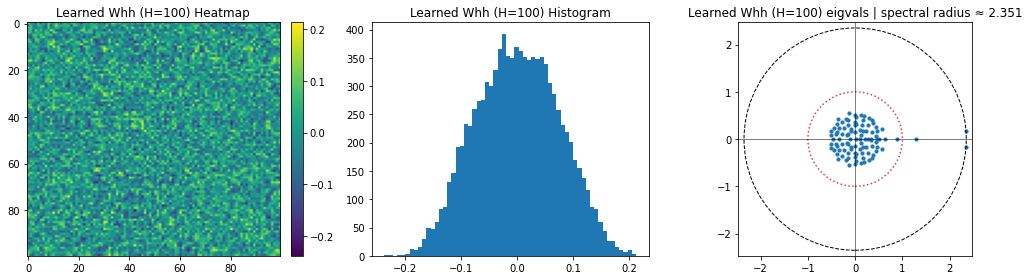

INITIAL SYMMETRY
[Learned (unsorted) — symmetric] var=0.00344412  σ_max=2.7836  ρ=2.7836  asym=0.0000  mean=5.806e-04
[Learned (unsorted) — skew] var=0.00201725  σ_max=1.1746  ρ=1.1746  asym=2.0000  mean=-2.980e-11


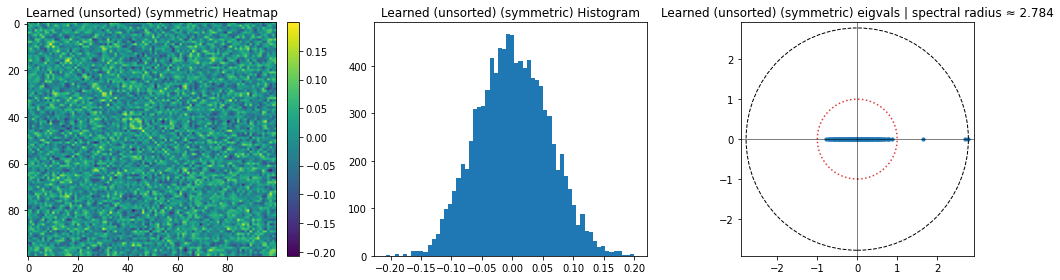

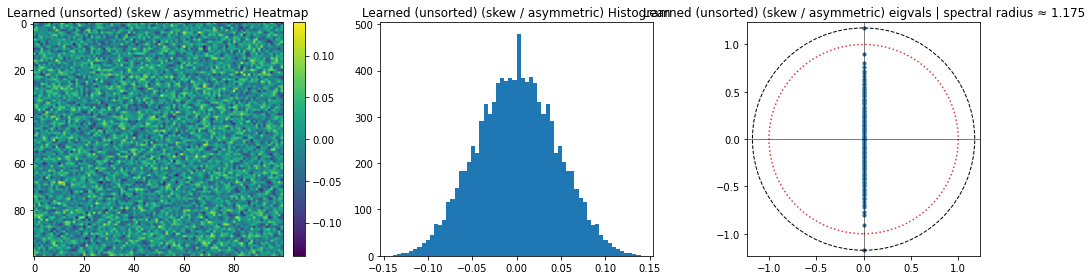

NORMALIZATION COMPARISON


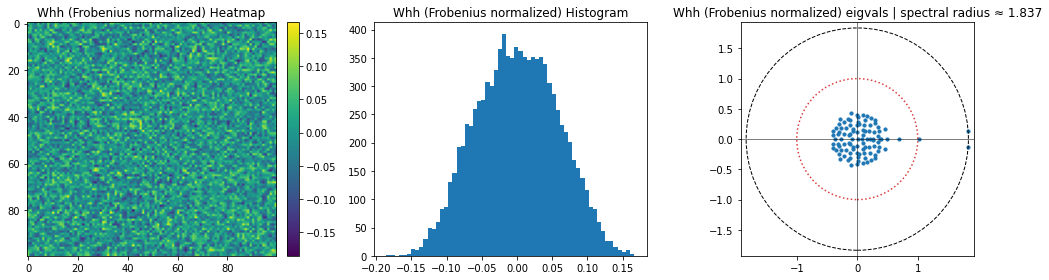

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/random_n100/frobenius/random_n100_fro_learned.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/random_n100/raw/random_n100_learned.npy and .json


In [15]:
# load PyTorch checkpoint from random init
import torch

path = "../runs/ElmanRNN/random-init/random_n100/run_04/random_n100.pth.tar"
ckpt = torch.load(path)

W = ckpt["weights"]["W_hh_history"][-1].astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/random_n100"
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"random_n{HIDDEN_N}_fro_learned",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"random_n{HIDDEN_N}_learned",
    meta={"norm": "raw"},
)

INITIAL MATRICES


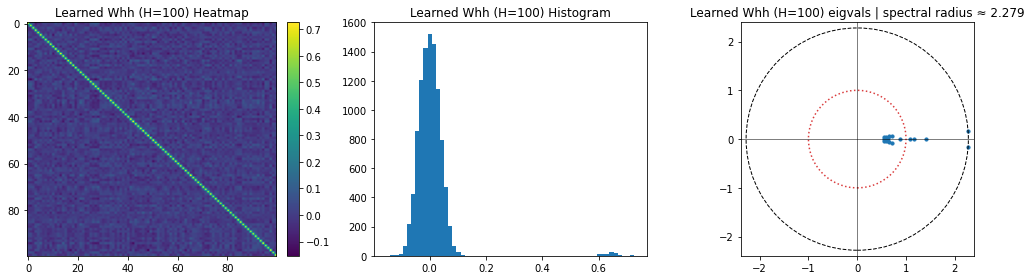

INITIAL SYMMETRY
[Learned (unsorted) — symmetric] var=0.00501653  σ_max=2.6088  ρ=2.6088  asym=0.0000  mean=6.531e-03
[Learned (unsorted) — skew] var=0.00030243  σ_max=0.8492  ρ=0.8492  asym=2.0000  mean=0.000e+00


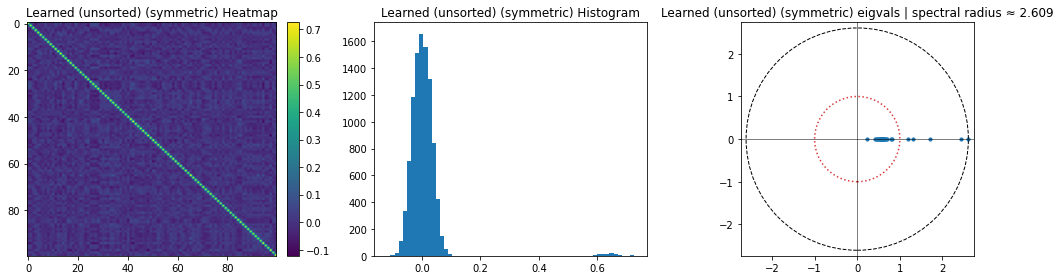

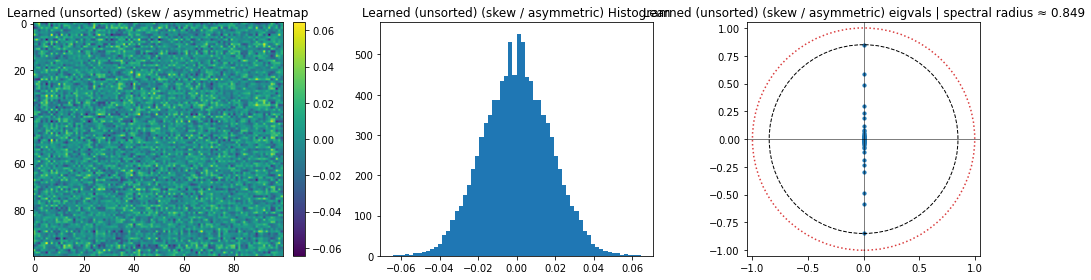

NORMALIZATION COMPARISON


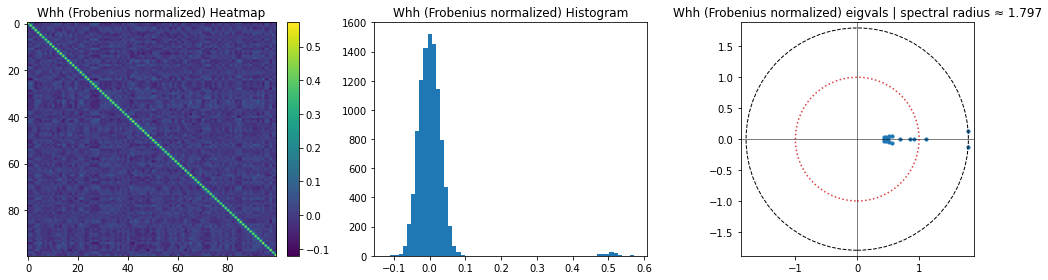

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/identity_n100/frobenius/identity_n100_fro_learned.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/identity_n100/raw/identity_n100_learned.npy and .json


In [16]:
# load PyTorch checkpoint from random init
import torch

path = "../runs/ElmanRNN/shift-variants/identity/frobenius/identity_n100_fro/run_00/identity_n100_fro.pth.tar"
ckpt = torch.load(path)

W = ckpt["weights"]["W_hh_history"][-1].astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/identity_n100"
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"identity_n{HIDDEN_N}_fro_learned",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"identity_n{HIDDEN_N}_learned",
    meta={"norm": "raw"},
)

In [ ]:
# load PyTorch checkpoint from random init
import torch

path = "../runs/ElmanRNN/shift-variants/identity/frobenius/identity_n100_fro/run_00/identity_n100_fro.pth.tar"
ckpt = torch.load(path)

W = ckpt["weights"]["W_hh_history"][-1].astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/identity_n100"
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"identity_n{HIDDEN_N}_fro_learned",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"identity_n{HIDDEN_N}_learned",
    meta={"norm": "raw"},
)

INITIAL MATRICES


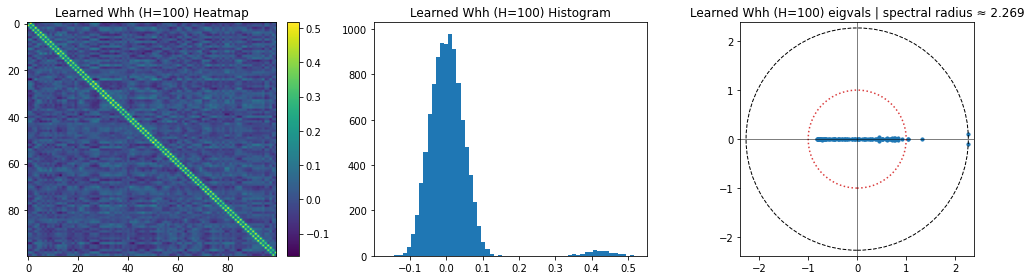

INITIAL SYMMETRY
[Learned (unsorted) — symmetric] var=0.00481382  σ_max=2.7554  ρ=2.7554  asym=0.0000  mean=9.782e-03
[Learned (unsorted) — skew] var=0.000465361  σ_max=1.0863  ρ=1.0863  asym=2.0000  mean=0.000e+00


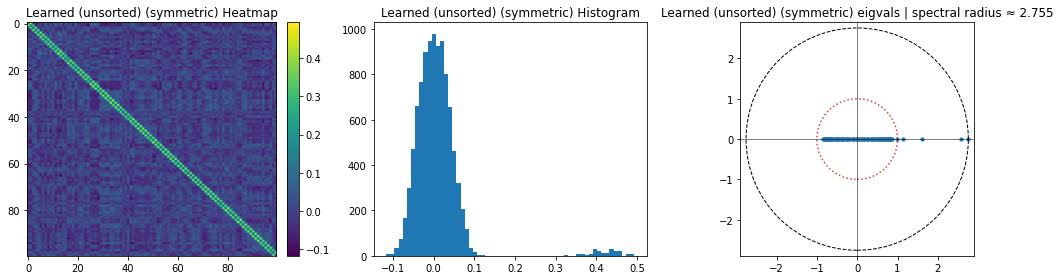

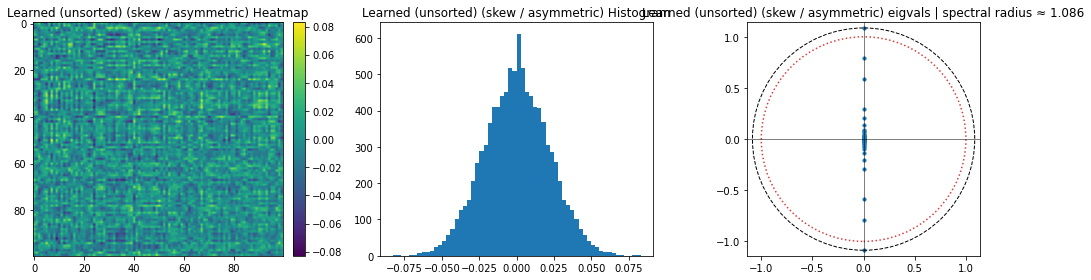

NORMALIZATION COMPARISON


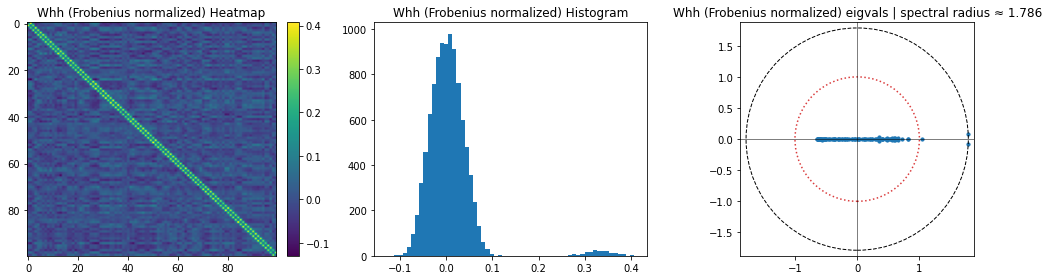

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shift_n100_fro_sym1p00/frobenius/shift_n100_fro_sym1p00_learned.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shift_n100_fro_sym1p00/raw/shift_n100_sym1p00_learned.npy and .json


In [17]:
# load PyTorch checkpoint from random init
import torch

path = "../runs/ElmanRNN/shift-variants/shift/frobenius/sym1p00/shift_n100_fro_sym1p00/run_00/shift_n100_fro_sym1p00.pth.tar"
ckpt = torch.load(path)

W = ckpt["weights"]["W_hh_history"][-1].astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shift_n100_fro_sym1p00"
)
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"shift_n{HIDDEN_N}_fro_sym1p00_learned",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"shift_n{HIDDEN_N}_sym1p00_learned",
    meta={"norm": "raw"},
)

INITIAL MATRICES


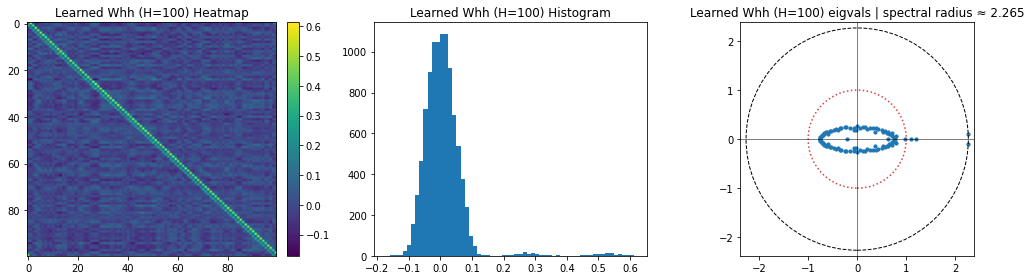

INITIAL SYMMETRY
[Learned (unsorted) — symmetric] var=0.00448284  σ_max=2.7666  ρ=2.7666  asym=0.0000  mean=9.511e-03
[Learned (unsorted) — skew] var=0.000775911  σ_max=1.0986  ρ=1.0986  asym=2.0000  mean=2.384e-11


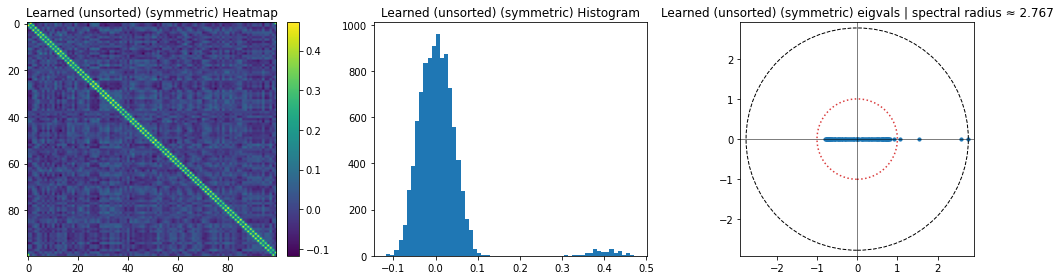

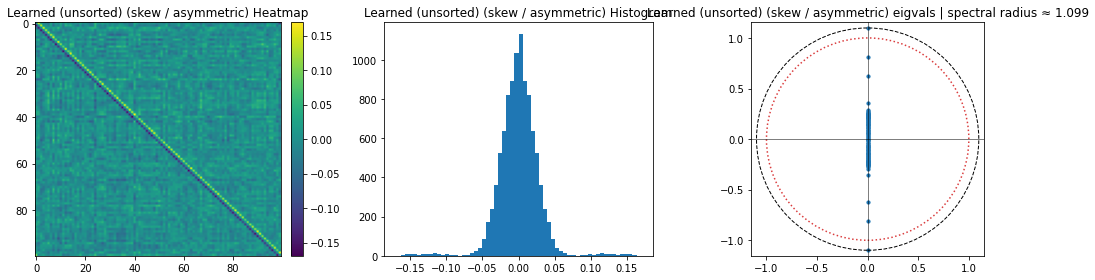

NORMALIZATION COMPARISON


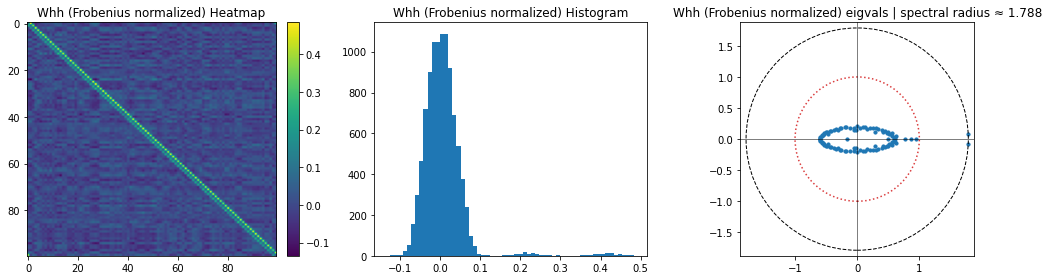

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shiftcyc_n100_fro_sym0p75/frobenius/shiftcyc_n100_fro_sym0p75_learned.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shiftcyc_n100_fro_sym0p75/raw/shiftcyc_n100_sym0p75_learned.npy and .json


In [ ]:
# load PyTorch checkpoint from random init
import torch

path = "../runs/ElmanRNN/shift-variants/shift-cyc/frobenius/sym0p75/shiftcyc_n100_fro_sym0p75/run_00/shiftcyc_n100_fro_sym0p75.pth.tar"
ckpt = torch.load(path)

W = ckpt["weights"]["W_hh_history"][-1].astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shiftcyc_n100_fro_sym0p75"
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"shiftcyc_n{HIDDEN_N}_fro_sym0p75_learned",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"shiftcyc_n{HIDDEN_N}_sym0p75_learned",
    meta={"norm": "raw"},
)